In [1]:
#https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
#https://scikit-learn.org/stable/modules/feature_selection.html


from pandas.plotting import scatter_matrix
from time import time
from datetime import datetime  
from datetime import timedelta 
from IPython.display import display 
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
import math 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from statistics import mean


data = pd.read_csv('creditcard.csv')

scaler = MinMaxScaler()

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

column_indices_selected = [12, 4, 17, 20, 6, 30]
column_names_selected = []
for selected_col_index in column_indices_selected:
    column_names_selected.append(data.columns[selected_col_index])

data = data[column_names_selected].copy()

data_pos = data[data.Class == 1.0]
data_neg = data[data.Class == 0.0]

validation_spilt_ratio = 0.5

data_pos_0 = data_pos.sample(frac=validation_spilt_ratio)
data_pos_1 = data_pos.drop(data_pos_0.index)

data_neg_0 = data_neg.sample(frac=validation_spilt_ratio)
data_neg_1 = data_neg.drop(data_neg_0.index)

data = pd.concat([data_pos_1, data_neg_1], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
data_validation = pd.concat([data_pos_0, data_neg_0], ignore_index=True)
data_validation = data_validation.sample(frac=1).reset_index(drop=True)

## Feature Correlation

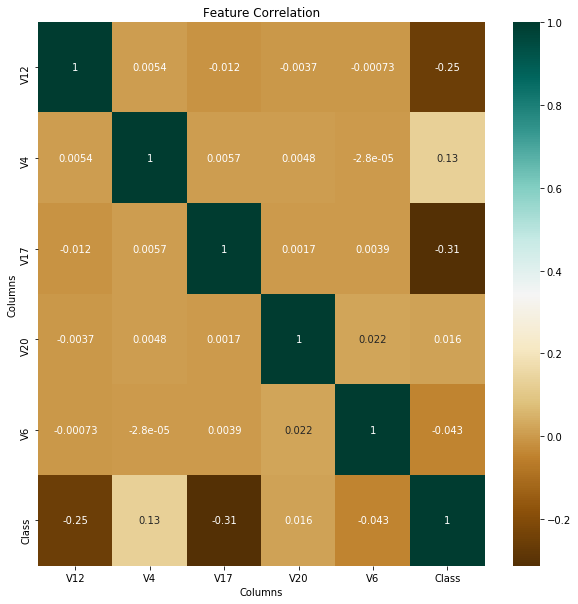

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, ax=ax, cmap='BrBG').set(title='Feature Correlation', xlabel='Columns', ylabel='Columns')
plt.show()

## Dataset Taget Value Distribution

As you can see in the pie chart below, data instances in our data frame 'data' are extremely imbalanced and only a tiny minority of them is fraudulent.

We will handle later on this imbalance problem via up-sampling.

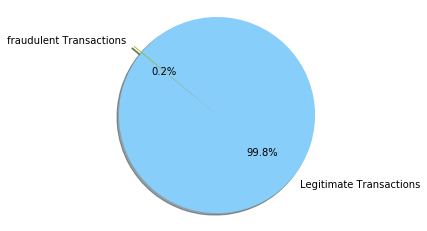

0.0    142157
1.0       246
Name: Class, dtype: int64

In [19]:

labels = 'fraudulent Transactions', 'Legitimate Transactions'
sizes = [data.Class.value_counts()[1], data.Class.value_counts()[0]]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data.Class.value_counts()

In [18]:
data.columns

Index(['V12', 'V4', 'V17', 'V20', 'V6', 'Class'], dtype='object')

In [2]:
data_validation.head()

,V12,V4,V17,V20,V6,Class
0,0.685670,0.252107,0.748723,0.577951,0.249142,0.0
1,0.708920,0.227702,0.725127,0.582202,0.261354,0.0
2,0.687543,0.207949,0.721794,0.582145,0.260525,0.0
3,0.694756,0.193287,0.745636,0.579202,0.262153,0.0
4,0.733998,0.228524,0.745163,0.581920,0.255136,0.0


In [3]:
data_validation.Class.value_counts()

0.0    142158
1.0       246
Name: Class, dtype: int64

In [4]:
data.shape

(142403, 6)

In [5]:
data_validation.shape

(142404, 6)

In [6]:
data_pos_1.shape

(246, 6)

# Up Sampling The Dataset

In [7]:
def up_sample_minority_class(df, random_state, is_future_selection_to_be_made):
    # Entries of the both minority and majority classes
    data_majority = df.loc[df['Class'] == 0.0]
    data_minority = df.loc[df['Class'] == 1.0]
    
    print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    #populates the minority portion of the samples up to the size of majority portion
    data_minority_up_sampled = resample(data_minority, 
                                     replace=True,
                                     n_samples=len(data_majority),
                                     random_state=random_state)
    
    # Combine majority class with upsampled minority class
    data_up_sampled = pd.concat([data_majority, data_minority_up_sampled])
    
    # Display new class counts
    print(data_up_sampled.Class.value_counts())
    
    X_up_sampled = np.array(data_up_sampled.drop(['Class'], 1).astype(float))
    y_up_sampled = np.array(data_up_sampled['Class']).astype(float)
    
    if is_future_selection_to_be_made:
        X_up_sampled = SelectKBest(chi2, k=10).fit_transform(X_up_sampled, y_up_sampled)
    
    X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled = train_test_split(X_up_sampled, y_up_sampled, random_state=random_state)
    
    return X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled, X_up_sampled, y_up_sampled

## Mid-Sampling

In [8]:
def mid_sample_minority_class(df, shrinkage_coefficient, random_state, is_future_selection_to_be_made):
    # Entries of the both minority and majority classes
    data_majority = df.loc[df['Class'] == 0.0]
    data_minority = df.loc[df['Class'] == 1.0]
    
    #print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    new_size = int(len(data_majority) / shrinkage_coefficient)
    
    #populates the minority portion of the samples mid to the size of majority portion
    data_minority_mid_sampled = resample(data_minority, 
                                     replace=True,
                                     n_samples=new_size,
                                     random_state=random_state)
    data_majority_mid_sampled = resample(data_majority, 
                                     replace=True,
                                     n_samples=new_size,
                                     random_state=random_state)
    
    # Combine majority class with midsampled minority class
    data_mid_sampled = pd.concat([data_majority_mid_sampled, data_minority_mid_sampled])
    
    # Display new class counts
    #print(data_mid_sampled.Class.value_counts())
    
    
    X_mid_sampled = np.array(data_mid_sampled.drop(['Class'], 1).astype(float))
    y_mid_sampled = np.array(data_mid_sampled['Class']).astype(float)
    
    if is_future_selection_to_be_made:
        X_mid_sampled = SelectKBest(chi2, k=10).fit_transform(X_mid_sampled, y_mid_sampled)
    
    
    X_train_mid_sampled, X_test_mid_sampled, y_train_mid_sampled, y_test_mid_sampled = train_test_split(X_mid_sampled, y_mid_sampled, random_state=random_state)
    
    #print("X_train_mid_sampled.shape: {0} @ y_test_mid_sampled.shape: {1}".format(X_train_mid_sampled.shape, y_test_mid_sampled.shape))
    
    
    return X_train_mid_sampled, X_test_mid_sampled, y_train_mid_sampled, y_test_mid_sampled, X_mid_sampled, y_mid_sampled

In [11]:

random_state = 16

X = np.array(data.drop(['Class'], 1).astype(float))
y = np.array(data['Class']).astype(float)


X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(data, random_state, False)



data_majority: 142157 @ data_minority: 246
1.0    142157
0.0    142157
Name: Class, dtype: int64


### Browse Different Model Classifiers

In [12]:
from sklearn.metrics import accuracy_score, fbeta_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data 
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start 
    
    # Get the predictions on the test set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute accuracy on the first 300 training samples 
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=2.0)
    
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=2.0)
    
    results['recall_cross_val_score'] = cross_val_score(learner, X, y, scoring="recall", cv = 10).mean()
    
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    # Return the results
    return results

In [13]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



# Initialize the three models
random_state = 55

clf_A = KNeighborsClassifier(n_neighbors=4)
clf_B = GaussianNB()
clf_D = DecisionTreeClassifier()
clf_E = RandomForestClassifier(random_state=random_state)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_B, clf_A, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([
        samples_1, samples_10]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
results

GaussianNB trained on 2132 samples.
GaussianNB trained on 21323 samples.
KNeighborsClassifier trained on 2132 samples.
KNeighborsClassifier trained on 21323 samples.
DecisionTreeClassifier trained on 2132 samples.
DecisionTreeClassifier trained on 21323 samples.
RandomForestClassifier trained on 2132 samples.
RandomForestClassifier trained on 21323 samples.


{'GaussianNB': {0: {'train_time': 0.0023941993713378906,
   'pred_time': 0.011862516403198242,
   'acc_train': 0.93,
   'acc_test': 0.9145457870819792,
   'f_train': 0.8914209115281503,
   'f_test': 0.879084157702789,
   'recall_cross_val_score': 0.8575940838212743},
  1: {'train_time': 0.003371000289916992,
   'pred_time': 0.006222724914550781,
   'acc_train': 0.93,
   'acc_test': 0.9149256461120725,
   'f_train': 0.8914209115281503,
   'f_test': 0.8763017526035053,
   'recall_cross_val_score': 0.8575940838212743}},
 'KNeighborsClassifier': {0: {'train_time': 0.0024671554565429688,
   'pred_time': 1.5372827053070068,
   'acc_train': 0.99,
   'acc_test': 0.9674024676768103,
   'f_train': 0.9960937499999999,
   'f_test': 0.9769764107618898,
   'recall_cross_val_score': 1.0},
  1: {'train_time': 0.012248516082763672,
   'pred_time': 1.694617748260498,
   'acc_train': 1.0,
   'acc_test': 0.9957371375511754,
   'f_train': 1.0,
   'f_test': 0.9982952435607466,
   'recall_cross_val_score': 1

# So best performing prediction model seems to be Random Forest

### Training without Up-Sampling

In [20]:

X = np.array(data.drop(['Class'], 1).astype(float))
y = np.array(data['Class']).astype(float)


time0 = time()

random_state = 18
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

print("random_state: {0}, positive cases' test set/all ratio:{1}".format(random_state, y_test.sum()/(y_train.sum() + y_test.sum())))


clf = RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=2.0)))


# print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X, y, scoring="accuracy", cv = 10).mean()))
# print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))
# print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
# print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

random_state: 18, positive cases' test set/all ratio:0.2682926829268293

Accuracy Score: 0.9991854161399961
Precision Score: 0.8363636363636363
Recall Score: 0.696969696969697
F-Beta Score: 0.7210031347962383

time elapsed: 2.4217731952667236



### Training After Up-Sampling

In [30]:

X = np.array(data.drop(['Class'], 1).astype(float))
y = np.array(data['Class']).astype(float)


time0 = time()
print("starting time: {0}".format(time0))


random_state = 62
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

print("random_state: {0}, positive cases' test set/all ratio:{1}".format(random_state, y_test.sum()/(y_train.sum() + y_test.sum())))

X_train, X_test, y_train, y_test, X, Y = up_sample_minority_class(data, random_state, False)


clf = RandomForestClassifier(max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=75, n_jobs=-2).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=2.0)))


print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X, y, scoring="accuracy", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

starting time: 1593941773.2096102
random_state: 62, positive cases' test set/all ratio:0.24982941395780722
data_majority: 142157 @ data_minority: 246
1.0    142157
0.0    142157
Name: Class, dtype: int64

Accuracy Score: 0.9999015180292351
Precision Score: 0.9998029390237037
Recall Score: 1.0
F-Beta Score: 0.9999605815904766


ValueError: Found input variables with inconsistent numbers of samples: [284314, 142403]

## Feature Selection with Boruta

In [34]:

X = np.array(data.drop(['Class'], 1).astype(float))
y = np.array(data['Class']).astype(float)

from boruta import BorutaPy 


random_state = 18
X_train, X_test, y_train, y_test, X, y = mid_sample_minority_class(data, 0.3, random_state, False)


clf = RandomForestClassifier(n_estimators=10, n_jobs=-2).fit(X_train, y_train)


# define Boruta feature selection method
feat_selector = BorutaPy(clf, n_estimators='auto', verbose=2, alpha=0.20)
 
# find all relevant features
feat_selector.fit(X, y)
 
# check selected features
feat_selector.support_
 
# check ranking of features
feat_selector.ranking_

print("feat_selector.ranking_: {0}, features: {1}".format(feat_selector.ranking_, feat_selector.support_))



X = np.array(data.drop(['Class'], 1).astype(float))
y = np.array(data['Class']).astype(float)


X = feat_selector.transform(X)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	6 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	0
feat_selector.ranking_: [1 1 1 1 1], features: [ True  True  True  True  True]


### sklearn.feature_selection

##### Shrink Vertically First

In [25]:

random_state = 34
# Entries of the both minority and majority classes
data_majority = data.loc[data['Class'] == 0.0]
data_minority = data.loc[data['Class'] == 1.0]

print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))

new_size = int(len(data_majority) / 120)

#populates the minority portion of the samples mid to the size of majority portion
data_minority_mid_sampled = resample(data_minority, 
                                 replace=True,
                                 n_samples=new_size,
                                 random_state=random_state)
data_majority_mid_sampled = resample(data_majority, 
                                 replace=True,
                                 n_samples=new_size,
                                 random_state=random_state)

# Combine majority class with midsampled minority class
data_mid_sampled = pd.concat([data_majority_mid_sampled, data_minority_mid_sampled])

# Display new class counts
print(data_mid_sampled.Class.value_counts())

X_mid = np.array(data_mid_sampled.drop(['Class'], 1).astype(float))
y_mid = np.array(data_mid_sampled['Class']).astype(float)



data_majority: 142157 @ data_minority: 246
1.0    1184
0.0    1184
Name: Class, dtype: int64


### default random forest performance BEFORE  sklearn.feature_selection

In [26]:
start_date = datetime.now()
print("start_date: {0}".format(start_date))
start_time = time()


random_state = 58
clf = RandomForestClassifier(random_state=random_state, n_jobs=-2)


#X = np.array(data.drop(['Class'], 1).astype(float))
#y = np.array(data['Class']).astype(float)
#print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
#print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))


print("\nCross-Validation Recall Score: {0}".format(cross_val_score(clf, X_mid, y_mid, scoring="recall", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X_mid, y_mid, scoring="precision", cv = 10).mean()))


end_time = time()
print("\nTotal Time Elapsed: {0} seconds\n------".format((end_time-start_time)))

start_date: 2020-07-05 12:33:48.307495

Cross-Validation Recall Score: 0.9991596638655462
Cross-Validation Precision Score: 0.9867679426828706

Total Time Elapsed: 5.231151342391968 seconds
------


In [9]:


X_filtered = SelectKBest(chi2, k=10).fit_transform(X_mid, y_mid)


### default random forest performance AFTER  sklearn.feature_selection

In [31]:
start_date = datetime.now()
print("start_date: {0}".format(start_date))
start_time = time()

random_state = 58
clf = RandomForestClassifier(random_state=random_state, n_jobs=-2)


print("\nCross-Validation Recall Score: {0}".format(cross_val_score(clf, X_filtered, y_mid, scoring="recall", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X_filtered, y_mid, scoring="precision", cv = 10).mean()))


end_time = time()
print("\nTotal Time Elapsed: {0} seconds\n------".format((end_time-start_time)))


start_date: 2020-07-05 12:38:19.152114


NameError: name 'X_filtered' is not defined

In [35]:

X = np.array(data.drop(['Class'], 1).astype(float))
y = np.array(data['Class']).astype(float)



start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()


#X_filtered = SelectKBest(chi2, k=10).fit_transform(X, y)

random_state = 54
X_train, X_test, y_train, y_test = up_sample_minority_class(random_state, True)


clf = RandomForestClassifier(max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=75, n_jobs=-2).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=2.0)))


#print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X, y, scoring="accuracy", cv = 10).mean()))
#print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
#print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-07-05 12:56:52.759824


ValueError: k should be >=0, <= n_features = 5; got 10. Use k='all' to return all features.

In [36]:


start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()


X_filtered = SelectKBest(chi2, k=10).fit_transform(X, y)

random_state = 54
X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(random_state, False)



clf = RandomForestClassifier(max_depth=20, n_estimators=25, n_jobs=-2).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=2.0)))


print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X, y, scoring="accuracy", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-07-05 12:56:57.587717


ValueError: k should be >=0, <= n_features = 5; got 10. Use k='all' to return all features.

In [9]:

#X = np.array(data.drop(['Class'], 1).astype(float))
#y = np.array(data['Class']).astype(float)



start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()


#X_filtered = SelectKBest(chi2, k=10).fit_transform(X, y)

random_state = 54
X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(random_state, True)



clf = RandomForestClassifier(max_depth=10, n_estimators=25, n_jobs=-2).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=2.0)))


print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X, y, scoring="accuracy", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-06-09 16:53:19.289978
data_majority: 284315 @ data_minority: 492
1.0    284315
0.0    284315
Name: Class, dtype: int64

Accuracy Score: 0.9935916374737968
Precision Score: 0.9989495649211464
Recall Score: 0.9882460328605533
F-Beta Score: 0.9903683500944306

Cross-Validation Accuracy Score: 0.9944638868860244
Cross-Validation Precision Score: 0.998614075633814
Cross-Validation Recall Score: 0.9910381158170122
Cross-Validation F-Beta Score: 0.9947971295349367

time elapsed: 461.07413363456726



In [38]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


X_train, X_test, y_train, y_test, X, y = mid_sample_minority_class(random_state, True)

# Initialize the three models
random_state = 55

clf_A = KNeighborsClassifier(n_neighbors=3)
clf_B = GaussianNB()
clf_C = DecisionTreeClassifier()
clf_D = RandomForestClassifier(random_state=random_state)
clf_E = SVC()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_D]: #, clf_B, clf_C, clf_E
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([
        samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

results

data_majority: 284315 @ data_minority: 492
1.0    2369
0.0    2369
Name: Class, dtype: int64
X_train_mid_sampled.shape: (3553, 10) @ y_test_mid_sampled.shape: (1185,)
KNeighborsClassifier trained on 35 samples.
KNeighborsClassifier trained on 355 samples.
KNeighborsClassifier trained on 3553 samples.
RandomForestClassifier trained on 35 samples.
RandomForestClassifier trained on 355 samples.
RandomForestClassifier trained on 3553 samples.


{'KNeighborsClassifier': {0: {'train_time': 0.00048661231994628906,
   'pred_time': 0.033147573471069336,
   'acc_train': 0.94,
   'acc_test': 0.9282700421940928,
   'f_train': 0.8936825885978427,
   'f_test': 0.8839003858295335,
   'recall_cross_val_score': 0.9915558177787313},
  1: {'train_time': 0.0006010532379150391,
   'pred_time': 0.034739017486572266,
   'acc_train': 0.9666666666666667,
   'acc_test': 0.9308016877637131,
   'f_train': 0.9484066767830047,
   'f_test': 0.9016678248783877,
   'recall_cross_val_score': 0.9915558177787313},
  2: {'train_time': 0.0035233497619628906,
   'pred_time': 0.04245495796203613,
   'acc_train': 0.9933333333333333,
   'acc_test': 0.9746835443037974,
   'f_train': 0.9970014992503747,
   'f_test': 0.9764826175869119,
   'recall_cross_val_score': 0.9915558177787313}},
 'RandomForestClassifier': {0: {'train_time': 0.08555364608764648,
   'pred_time': 0.018020153045654297,
   'acc_train': 0.9366666666666666,
   'acc_test': 0.9248945147679325,
   'f_

# Train Model & Validate in Random Forest

In [78]:


start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()


random_state = 3
shrinkage_coefficient = 140

#X = np.array(data.drop(['Class'], 1).astype(float))
#y = np.array(data['Class']).astype(float)



#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)


X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(data, random_state, False)



clf = RandomForestClassifier(max_depth=10, n_estimators=300, class_weight="balanced", n_jobs=-2).fit(X_train, y_train)

#clf = RandomForestClassifier(max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=7, n_estimators=55, n_jobs=-2).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=2.0)))


print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X, y, scoring="accuracy", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X, y, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X, y, scoring="recall", cv = 10).mean()))
print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-06-11 00:36:29.183964
data_majority: 142157 @ data_minority: 246
1.0    142157
0.0    142157
Name: Class, dtype: int64

Accuracy Score: 0.9994794524402425
Precision Score: 0.9989527017464406
Recall Score: 1.0
F-Beta Score: 0.9997903647087486

Cross-Validation Accuracy Score: 0.9995673795794684
Cross-Validation Precision Score: 0.9991355553215939
Cross-Validation Recall Score: 1.0
Cross-Validation F-Beta Score: 0.9995535263143648

time elapsed: 861.7080018520355



In [79]:


start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()



random_state = 3



X_validation = np.array(data_validation.drop(['Class'], 1).astype(float))
y_validation = np.array(data_validation['Class']).astype(float)

#X_validation = SelectKBest(chi2, k=10).fit_transform(X_validation, y_validation)

X_train_validation, X_test_validation, y_train_validation, y_test_validation = train_test_split(X_validation, y_validation, random_state=random_state)


#X_train_validation, X_test_validation, y_train_validation, y_test_validation, X_validation, y_validation = up_sample_minority_class(data_validation, random_state, True)



# threshold = 0.5

# prediction_probablities = clf.predict_proba(X_test_validation)
# predictions = (prediction_probablities [:,1] >= threshold).astype('float')


predictions = clf.predict(X_test_validation)
solid_predictions = predictions
print("solid_predictions.sum: {}".format(solid_predictions.sum()))

print("\nAccuracy Score: {0}".format(accuracy_score(y_test_validation, predictions)))
print("Precision Score: {0}".format(precision_score(y_test_validation, predictions)))
print("Recall Score: {0}".format(recall_score(y_test_validation, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test_validation, predictions, beta=2.0)))


# print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf, X_validation, y_validation, scoring="accuracy", cv = 10).mean()))
# print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf, X_validation, y_validation, scoring="precision", cv = 10).mean()))
# print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf, X_validation, y_validation, scoring="recall", cv = 10).mean()))
# print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf, X_validation, y_validation, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-06-11 00:50:50.910699
solid_predictions.sum: 76.0

Accuracy Score: 0.9986798123648212
Precision Score: 0.6447368421052632
Recall Score: 0.7101449275362319
F-Beta Score: 0.6960227272727273

time elapsed: 0.26491737365722656



In [87]:


start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()

accuracy_scores = []
precision_scores = []
recall_scores = []
beta_2_0_scores = []

for random_state in range(0,100):

    X_validation = np.array(data_validation.drop(['Class'], 1).astype(float))
    y_validation = np.array(data_validation['Class']).astype(float)

    #X_validation = SelectKBest(chi2, k=10).fit_transform(X_validation, y_validation)

    X_train_validation, X_test_validation, y_train_validation, y_test_validation = train_test_split(X_validation, y_validation, random_state=random_state)



    #X_train_validation, X_test_validation, y_train_validation, y_test_validation, X_validation, y_validation = up_sample_minority_class(data_validation, random_state, True)


    threshold = 0.7

    prediction_probablities = clf.predict_proba(X_test_validation)
    predictions = (prediction_probablities [:,1] >= threshold).astype('float')
    
    accuracy_scores.append(accuracy_score(y_test_validation, predictions))
    precision_scores.append(precision_score(y_test_validation, predictions))
    recall_scores.append(recall_score(y_test_validation, predictions))
    beta_2_0_scores.append(fbeta_score(y_test_validation, predictions, beta=2.0))




print("\nCross-Validation Accuracy Score: {0}".format(mean(accuracy_scores)))
print("Cross-Validation Precision Score: {0}".format(mean(precision_scores)))
print("Cross-Validation Recall Score: {0}".format(mean(recall_scores)))
print("Cross-Validation F-Beta Score: {0}".format(mean(beta_2_0_scores)))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-06-11 01:00:15.339069

Cross-Validation Accuracy Score: 0.9976377068059886
Cross-Validation Precision Score: 0.4092166132408541
Cross-Validation Recall Score: 0.8324965984526776
Cross-Validation F-Beta Score: 0.6885573901857066

time elapsed: 17.248565912246704



In [80]:
def two_sworded_predictions(solid_predictions, assisting_predictions):
    if len(solid_predictions) != len(assisting_predictions):
        print("2 prediction arrays provided as parameters are not equal in size! solid_predictions: {0}, assisting_predictions: {1}".format(len(solid_predictions), len(assisting_predictions)))
        return
    
    result = len(solid_predictions) * [0.0]
    for i in range(0, len(solid_predictions)):
        if solid_predictions[i] == 1.0:
            result[i] = 1.0
        else:
            result[i] = assisting_predictions[i]
    
    return result

array([0., 0., 0., ..., 0., 0., 0.])

# Train Model & Validate in K-Nearest Neighbour

In [110]:


start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()


random_state = 52
X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(data, random_state, True)



#clf = RandomForestClassifier(max_depth=10, n_estimators=25, n_jobs=-2).fit(X_train, y_train)

clf_KNN = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)



predictions_KNN = clf_KNN.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions_KNN)))
print("Precision Score: {0}".format(precision_score(y_test, predictions_KNN)))
print("Recall Score: {0}".format(recall_score(y_test, predictions_KNN)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions_KNN, beta=2.0)))


print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf_KNN, X, y, scoring="accuracy", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf_KNN, X, y, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf_KNN, X, y, scoring="recall", cv = 10).mean()))
print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf_KNN, X, y, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

start_date: 2020-06-09 19:39:16.897731
data_majority: 142158 @ data_minority: 246
1.0    142158
0.0    142158
Name: Class, dtype: int64

Accuracy Score: 0.9996904852347388
Precision Score: 0.9993792675356921
Recall Score: 1.0
F-Beta Score: 0.9998757918271023

Cross-Validation Accuracy Score: 0.9997502786515081
Cross-Validation Precision Score: 0.9995008352340065
Cross-Validation Recall Score: 1.0
Cross-Validation F-Beta Score: 0.999750347783461

time elapsed: 101.08400559425354



In [113]:


random_state = 51



X_validation = np.array(data_validation.drop(['Class'], 1).astype(float))
y_validation = np.array(data_validation['Class']).astype(float)

X_validation = SelectKBest(chi2, k=10).fit_transform(X_validation, y_validation)

X_train_validation, X_test_validation, y_train_validation, y_test_validation = train_test_split(X_validation, y_validation, random_state=random_state)


predictions_KNN = clf_KNN.predict(X_test_validation)



print("\nAccuracy Score: {0}".format(accuracy_score(y_test_validation, predictions_KNN)))
print("Precision Score: {0}".format(precision_score(y_test_validation, predictions_KNN)))
print("Recall Score: {0}".format(recall_score(y_test_validation, predictions_KNN)))
print("F-Beta Score: {0}".format(fbeta_score(y_test_validation, predictions_KNN, beta=2.0)))


print("\nCross-Validation Accuracy Score: {0}".format(cross_val_score(clf_KNN, X_validation, y_validation, scoring="accuracy", cv = 10).mean()))
print("Cross-Validation Precision Score: {0}".format(cross_val_score(clf_KNN, X_validation, y_validation, scoring="precision", cv = 10).mean()))
print("Cross-Validation Recall Score: {0}".format(cross_val_score(clf_KNN, X_validation, y_validation, scoring="recall", cv = 10).mean()))
print("Cross-Validation F-Beta Score: {0}".format(cross_val_score(clf_KNN, X_validation, y_validation, scoring="f1", cv = 10).mean()))


time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))



Accuracy Score: 0.9989887924496503
Precision Score: 0.625
Recall Score: 0.8333333333333334
F-Beta Score: 0.78125

Cross-Validation Accuracy Score: 0.9993469244127378
Cross-Validation Precision Score: 0.9035462989023362
Cross-Validation Recall Score: 0.728
Cross-Validation F-Beta Score: 0.7931186987492125

time elapsed: 497.77337098121643



In [125]:

threshold = 0.001

prediction_probablities = clf_KNN.predict_proba(X_test_validation)
predictions = (prediction_probablities [:,1] >= threshold).astype('float')
predictions.sum()

99.0

In [56]:
solid_predictions.sum()

368.0

## My Custom Parameter Tuning Algorithm

In [81]:


start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()

# max_depth_values = [5, 15, 30]
# n_estimators_values = [50, 75, 125]
# min_impurity_decrease_values = [0.0, 0.25, 0.5, 0.75]
# threshold_values = [0.1, 0.2, 0.3, 0.5]


max_depth_values = [15]
min_samples_leaf_values = [6]
n_estimators_values = [60]
threshold_values = [0.38]
shrinkage_coefficient_values = [140]

for ia in range(0, len(max_depth_values)):
    for ib in range(0, len(min_samples_leaf_values)):
        for ic in range(0, len(n_estimators_values)):
            for ie in range(0, len(threshold_values)):
                for ig in range(0, len(shrinkage_coefficient_values)):
                    
                    random_state = 52
                    shrinkage_coefficient = 140
                    
                    print("\n\nmax_depth: {0},  min_samples_leaf: {1},  n_estimators: {2},  threshold: {3},  shrinkage_coefficient:{4}".format(max_depth_values[ia], min_samples_leaf_values[ib], n_estimators_values[ic], threshold_values[ie], shrinkage_coefficient))
                    
                    
                    X = np.array(data.drop(['Class'], 1).astype(float))
                    y = np.array(data['Class']).astype(float)
                    
                    
                    #  min_samples_leaf=min_samples_leaf_values[ib], 
                    
                    
                    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
                    
                    
                    X_train, X_test, y_train, y_test, X, y = mid_sample_minority_class(data, shrinkage_coefficient, random_state, False)
                    
                    
                    clf = RandomForestClassifier(max_depth=max_depth_values[ia], n_estimators=n_estimators_values[ic], class_weight="balanced", n_jobs=-2).fit(X_train, y_train)
                    
                    #clf = RandomForestClassifier(max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=7, n_estimators=55, n_jobs=-2).fit(X_train, y_train)
                    
                    
                    accuracy_scores = []
                    precision_scores = []
                    recall_scores = []
                    beta_2_0_scores = []
                    
                    for random_state in range(0,100):
                        
                        X_validation = np.array(data_validation.drop(['Class'], 1).astype(float))
                        y_validation = np.array(data_validation['Class']).astype(float)
                        
                        #X_validation = SelectKBest(chi2, k=10).fit_transform(X_validation, y_validation)
                        
                        X_train_validation, X_test_validation, y_train_validation, y_test_validation = train_test_split(X_validation, y_validation, random_state=random_state)
                        
                        
                        
                        #X_train_validation, X_test_validation, y_train_validation, y_test_validation, X_validation, y_validation = up_sample_minority_class(data_validation, random_state, True)
                        
                        
                        threshold = threshold_values[ie]
                        threshold = 0.9
                        
                        #predictions = clf.predict(X_test_validation)
                        
                        prediction_probablities = clf.predict_proba(X_test_validation)
                        predictions = (prediction_probablities [:,1] >= threshold).astype('float')
                        
                        # employ prediction with 2 models (2 handed sword)
                        predictions = two_sworded_predictions(solid_predictions, predictions)
                        
                        accuracy_scores.append(accuracy_score(y_test_validation, predictions))
                        precision_scores.append(precision_score(y_test_validation, predictions))
                        recall_scores.append(recall_score(y_test_validation, predictions))
                        beta_2_0_scores.append(fbeta_score(y_test_validation, predictions, beta=2.0))
                        
                    print("Cross-Validation Accuracy Score: {0}".format(mean(accuracy_scores)))
                    print("Cross-Validation Precision Score: {0}".format(mean(precision_scores)))
                    print("Cross-Validation Recall Score: {0}".format(mean(recall_scores)))
                    print("Cross-Validation F-Beta Score: {0}".format(mean(beta_2_0_scores)))

time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))




start_date: 2020-06-11 00:53:11.357759


max_depth: 15,  min_samples_leaf: 6,  n_estimators: 60,  threshold: 0.38,  shrinkage_coefficient:140
Cross-Validation Accuracy Score: 0.9971250807561586
Cross-Validation Precision Score: 0.3438972174889745
Cross-Validation Recall Score: 0.7347491857653068
Cross-Validation F-Beta Score: 0.5972072799898116

time elapsed: 22.360724210739136



In [63]:
solid_predictions.sum()

509.0

In [55]:
prediction_probablities = clf.predict_proba(X_test_validation)
(prediction_probablities[:,1]>0.9).astype(float).sum()

54.0

# My Custom Feature Selection Algorithm

In [9]:

start_date = datetime.now()
print("start_date: {0}".format(start_date))
time0 = time()

previous_best_column_indices = []
previous_best_beta_2_0_score = 0.0

for j in range(0, len(data_validation.columns) - 1):
    
    print("\n\nSTEP NO {0}".format(j))
    print("STEP NO {0}".format(j))
    print("STEP NO {0}".format(j))
    
    best_beta_2_0_score = 0.0
    best_column_index_beta_2_0_score = -1
    
    for i in range(0, len(data.columns) - 1):
        
        if i not in previous_best_column_indices:
            column_names_included = []
            for prev_best_col_index in previous_best_column_indices:
                column_names_included.append(data.columns[prev_best_col_index])
            column_names_included.append(data.columns[i])
            column_names_included.append(data.columns[len(data.columns)-1])
            
            data_tr = data[column_names_included].copy().reset_index().drop(['index'], axis=1)
            #data_tr = data.drop([data.columns[i]], axis=1)
            data_val = data_validation[column_names_included].copy().reset_index().drop(['index'], axis=1)
            #data_val = data_validation.drop([data_validation.columns[i]], axis=1)
            
            X_train, X_test, y_train, y_test, X, y = mid_sample_minority_class(data_tr, 140, 32, False)
            clf = RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=50, n_jobs=-2).fit(X_train, y_train)
            
            
            precision_scores = []
            recall_scores = []
            beta_2_0_scores = []
            
            
            for random_state in range(0,100):
                
                X_validation = np.array(data_val.drop(['Class'], 1).astype(float))
                y_validation = np.array(data_val['Class']).astype(float)
                
                
                #X_train_validation, X_test_validation, y_train_validation, y_test_validation = train_test_split(X_validation, y_validation, random_state=random_state)
                
                X_train_validation, X_test_validation, y_train_validation, y_test_validation, X_validation, y_validation = mid_sample_minority_class(data_val, 140, 32, False)
                
                
                predictions = clf.predict(X_test_validation)
                
                precision_scores.append(precision_score(y_test_validation, predictions))
                recall_scores.append(recall_score(y_test_validation, predictions))
                beta_2_0_scores.append(fbeta_score(y_test_validation, predictions, beta=2.0))
                
            if beta_2_0_scores[len(beta_2_0_scores)-1] > best_beta_2_0_score:
                best_beta_2_0_score = beta_2_0_scores[len(beta_2_0_scores)-1]
                best_column_index_beta_2_0_score = i
            
            print("\n\nColumn: {0}".format(data.columns[i]))
            print("Cross-Validation Precision Score: {0}".format(mean(precision_scores)))
            print("Cross-Validation Recall Score: {0}".format(mean(recall_scores)))
            print("Cross-Validation F-Beta Score: {0}".format(mean(beta_2_0_scores)))
        
        
    time1 = time()
    diff = time1-time0
    print("\n\ntime elapsed: {0}\n".format(diff))
    
    
    if best_beta_2_0_score > previous_best_beta_2_0_score:
        print("\n\nBest column is {0} with index {1} and best f-beta 2.0 score is {2}\n".format(data_validation.columns[best_column_index_beta_2_0_score], best_column_index_beta_2_0_score, best_beta_2_0_score))
        previous_best_column_indices.append(best_column_index_beta_2_0_score)
        previous_best_beta_2_0_score = best_beta_2_0_score
    else:
        print("\n\n\n\nNo more better column to add!")
        print("previous_best_column_indices 1st print >>> \n{0}".format(previous_best_column_indices))
        print("all_best_beta_2_0_score 1st print >>> \n{0}".format(previous_best_beta_2_0_score))
        break



print("previous_best_column_indices 2nd print >>> \n{0}".format(previous_best_column_indices))
print("all_best_beta_2_0_score 2nd print >>> \n{0}".format(previous_best_beta_2_0_score))



time1 = time()
diff = time1-time0
print("\n\nFINAL - TOTAL TIME ELAPSED: {0}\n".format(diff))


start_date: 2020-06-10 19:32:49.204819


STEP NO 0
STEP NO 0
STEP NO 0


Column: Time
Cross-Validation Precision Score: 0.746606334841629
Cross-Validation Recall Score: 0.6
Cross-Validation F-Beta Score: 0.6245268735806208


Column: V1
Cross-Validation Precision Score: 0.7874015748031497
Cross-Validation Recall Score: 0.7272727272727273
Cross-Validation F-Beta Score: 0.7385524372230429


Column: V2
Cross-Validation Precision Score: 0.8810572687224669
Cross-Validation Recall Score: 0.7272727272727273
Cross-Validation F-Beta Score: 0.7535795026375282


Column: V3
Cross-Validation Precision Score: 0.8693877551020408
Cross-Validation Recall Score: 0.7745454545454545
Cross-Validation F-Beta Score: 0.7918215613382901


Column: V4
Cross-Validation Precision Score: 0.9015748031496063
Cross-Validation Recall Score: 0.8327272727272728
Cross-Validation F-Beta Score: 0.845642540620384


Column: V5
Cross-Validation Precision Score: 0.774869109947644
Cross-Validation Recall Score: 0.5381818181818182



Column: V19
Cross-Validation Precision Score: 0.9404761904761905
Cross-Validation Recall Score: 0.8618181818181818
Cross-Validation F-Beta Score: 0.8764792899408284


Column: V20
Cross-Validation Precision Score: 0.9556451612903226
Cross-Validation Recall Score: 0.8618181818181818
Cross-Validation F-Beta Score: 0.879080118694362


Column: V21
Cross-Validation Precision Score: 0.9426229508196722
Cross-Validation Recall Score: 0.8363636363636363
Cross-Validation F-Beta Score: 0.8556547619047619


Column: V22
Cross-Validation Precision Score: 0.9467213114754098
Cross-Validation Recall Score: 0.84
Cross-Validation F-Beta Score: 0.859375


Column: V23
Cross-Validation Precision Score: 0.9465020576131687
Cross-Validation Recall Score: 0.8363636363636363
Cross-Validation F-Beta Score: 0.8562918838421444


Column: V24
Cross-Validation Precision Score: 0.9621848739495799
Cross-Validation Recall Score: 0.8327272727272728
Cross-Validation F-Beta Score: 0.8557548579970103


Column: V25
Cross-Val



Column: V8
Cross-Validation Precision Score: 0.9728682170542635
Cross-Validation Recall Score: 0.9127272727272727
Cross-Validation F-Beta Score: 0.9241531664212077


Column: V9
Cross-Validation Precision Score: 0.9651162790697675
Cross-Validation Recall Score: 0.9054545454545454
Cross-Validation F-Beta Score: 0.9167893961708393


Column: V10
Cross-Validation Precision Score: 0.9723320158102767
Cross-Validation Recall Score: 0.8945454545454545
Cross-Validation F-Beta Score: 0.909090909090909


Column: V11
Cross-Validation Precision Score: 0.9645669291338582
Cross-Validation Recall Score: 0.8909090909090909
Cross-Validation F-Beta Score: 0.9047267355982272


Column: V12
Cross-Validation Precision Score: 0.9645669291338582
Cross-Validation Recall Score: 0.8909090909090909
Cross-Validation F-Beta Score: 0.9047267355982272


Column: V13
Cross-Validation Precision Score: 0.9612403100775194
Cross-Validation Recall Score: 0.9018181818181819
Cross-Validation F-Beta Score: 0.9131075110456555





Column: V27
Cross-Validation Precision Score: 0.9616858237547893
Cross-Validation Recall Score: 0.9127272727272727
Cross-Validation F-Beta Score: 0.9221160911094785


Column: V28
Cross-Validation Precision Score: 0.9768339768339769
Cross-Validation Recall Score: 0.92
Cross-Validation F-Beta Score: 0.930831493745401


Column: Amount
Cross-Validation Precision Score: 0.9651162790697675
Cross-Validation Recall Score: 0.9054545454545454
Cross-Validation F-Beta Score: 0.9167893961708393


time elapsed: 1815.3623776435852



Best column is V6 with index 6 and best f-beta 2.0 score is 0.9361233480176211



STEP NO 5
STEP NO 5
STEP NO 5


Column: Time
Cross-Validation Precision Score: 0.9766536964980544
Cross-Validation Recall Score: 0.9127272727272727
Cross-Validation F-Beta Score: 0.924834193072955


Column: V1
Cross-Validation Precision Score: 0.9730769230769231
Cross-Validation Recall Score: 0.92
Cross-Validation F-Beta Score: 0.9301470588235292


Column: V2
Cross-Validation Precision Sc